# Local Clustering
In this notebook we want to explore the *local* dynamics in the data.

This consideration comes from the common knowledge that the complaints like *noise* tend to cluster up spatially and temporally. Given the recent history we may expect local increase in volume for the complaints with the same type, so, we can try to use *kNN* to solve *Complaint Type* [classification problem](Classification.ipynb). (Though, the potential multi-label is still a challenge.)

In [1]:
import os, re, math
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from geopy.distance import geodesic
from IPython.core.display import display, HTML
%matplotlib inline

In [2]:
with open('header','r') as source:
    FEATURES = source.read().strip().split(',')
    
YEARS = np.arange(2010, 2020)

In [3]:
# memoization table
lookup = dict()
# get feature value given the index
def get_name(f,i):
    if int(i) == 0:
        return 'Other'
    if not f in lookup:
        try: # check if we have local index (updated categorization)
            index = pd.read_csv('./data/local-{}'.format(FEATURES.index(f)), header = None)[0]
        except FileNotFoundError:
            index = pd.read_csv('./data/index-{}.csv'.format(FEATURES.index(f)))['value']
        lookup[f] = index.tolist()
    return lookup[f][int(i) - 1]

In [4]:
YEAR = 2018

data = pd.read_csv('data/{}.csv'.format(YEAR)).set_index('Unique Key')

#### K Nearest Neighbors approach
For this experiment we need to define the similarity metric. Let us start from a simple assumption that the complaints originated within a day and a mile from each other are likely to be related.

In [5]:
# features for this simple model
F = data[['Created Date','AmPm','Latitude','Longitude','Complaint Type']].dropna()

In [6]:
# scaled time-space features
X = np.empty((F.shape[0], 3))
# ~elapsed time in days
X[:,0] = ((F['Created Date'].str.split('-', expand = True).astype(int)\
               .join(F[['AmPm']])).values * np.array([365., 30., 1., 1.])).sum(axis = 1)
# ~miles (lat deq ~ 69 miles; lng deg ~ 55 miles)
X[:,1:] = F[['Latitude','Longitude']].values * np.array([69., 55.])

In [7]:
# target
Y = F['Complaint Type'].astype(int).values

In [8]:
# split index into train and test segments
def tt_split(n, ration = 0.8):
    permute = np.random.choice(n, n, replace = False)
    cut = int(0.8 * n)
    return permute[:cut], permute[cut:]

In [9]:
train, test = tt_split(len(Y))
len(train), len(test)

(1941820, 485455)

In [10]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X[train], Y[train])
prediction = knn.predict(X[test])
print('Score: {:.2%}'.format((prediction == Y[test]).sum()/len(test)))

Score: 23.25%


In [11]:
for k in [3,5,7]:
    train, test = tt_split(len(Y))
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X[train], Y[train])
    prediction = knn.predict(X[test])
    print('k = {}  score: {:.2%}'.format(k, (prediction == Y[test]).sum()/len(test)))

k = 3  score: 24.27%
k = 5  score: 23.06%
k = 7  score: 22.63%


We might get better result if we filter the applicable categories and tune up the settings (scale, model parameters, etc.). Otherwise, it comes in the same ballpark as [NN-classifier](Classification.ipynb). We can combine the two and use ensamble model.

#### Convolutions?
Time and space convolution may also work.

In [12]:
FEATURES.index('City'), FEATURES.index('Street Name') 

(16, 10)

In [13]:
# most common city
!head -n5 ./data/dict-16.csv

value,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,total
BROOKLYN,604021,590496,535163,540828,631071,678905,702602,755846,848926,743305,6631163
NEW YORK,365642,351366,329152,356915,412335,457738,503476,469055,498035,450914,4194628
BRONX,380242,361459,322314,325332,378414,399300,425238,435441,466654,417778,3912172
STATEN ISL,100545,99986,86908,85349,102751,108311,109933,129089,152943,125941,1101756


In [14]:
# most common street
!head -n5 ./data/dict-10.csv

value,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,total
BRDWAY,15878,15172,14683,16699,18933,21834,28956,25683,25769,25081,208688
GRAND CONCOURSE,13225,12067,11090,12745,14324,13685,13580,13592,13900,11597,129805
OCEAN AVE,9249,9341,7822,8489,8814,8615,9043,8443,9265,8026,87107
5 AVE,5831,5158,5684,6542,6568,7380,9569,9533,9852,10910,77027


In [15]:
data['Created Date'] = pd.to_datetime(data['Created Date'], infer_datetime_format = True)

In [16]:
# show sequential frames with specified conditions
def plot_serie(D, frame, color, cmap = 'rainbow'):
    # frame: column to group by
    # color: column to color by
    serie = D.groupby(frame).size().index
    n, rows = len(serie), len(serie)//5 + (len(serie)%5 > 0)
    for r in range(rows):
        start = r * 5
        fig, ax = plt.subplots(1, 5, figsize = (16, 3))
        for i in range(5):
            if start + i < n:
                v = serie[start + i]
                d = D[D[frame] == v]
                ax[i].scatter(d['Longitude'], d['Latitude'], c = d[color], cmap = cmap, s = 1, alpha = .3)
                ax[i].set_xlabel(v)
                ax[i].set_xticks([])
                ax[i].set_yticks([])
            else:
                ax[i].axis('off')
        plt.show()

In [17]:
# August New York City
data['Date'] = data['Created Date'].dt.strftime('%b-%d')
cond = (data['City'] == 2) & (data['Created Date'].dt.month == 8)

In [18]:
D = data[cond][['Date','Agency','Latitude','Longitude']].dropna()
D.groupby('Date').size().index

Index(['Aug-01', 'Aug-02', 'Aug-03', 'Aug-04', 'Aug-05', 'Aug-06', 'Aug-07',
       'Aug-08', 'Aug-09', 'Aug-10', 'Aug-11', 'Aug-12', 'Aug-13', 'Aug-14',
       'Aug-15', 'Aug-16', 'Aug-17', 'Aug-18', 'Aug-19', 'Aug-20', 'Aug-21',
       'Aug-22', 'Aug-23', 'Aug-24', 'Aug-25', 'Aug-26', 'Aug-27', 'Aug-28',
       'Aug-29', 'Aug-30', 'Aug-31'],
      dtype='object', name='Date')

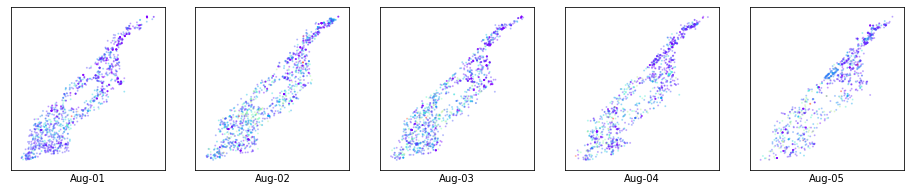

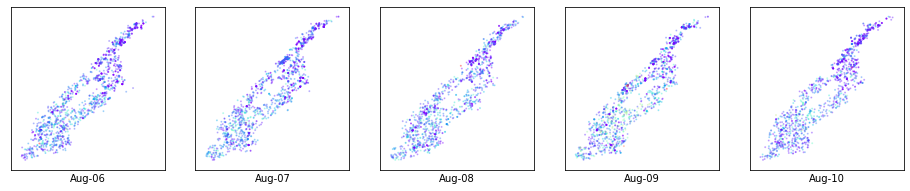

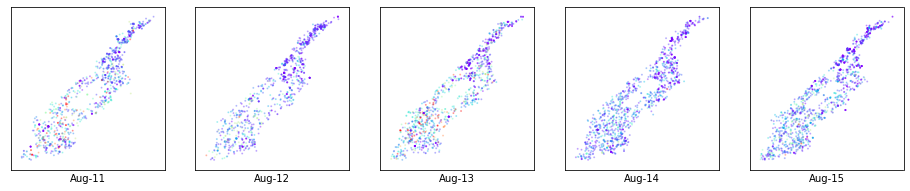

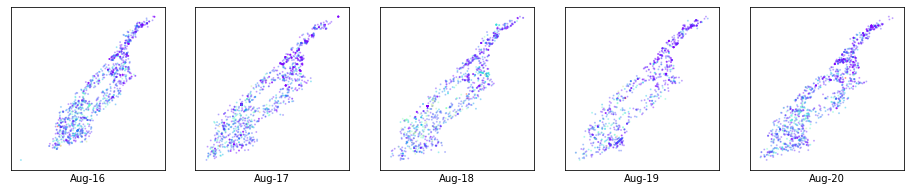

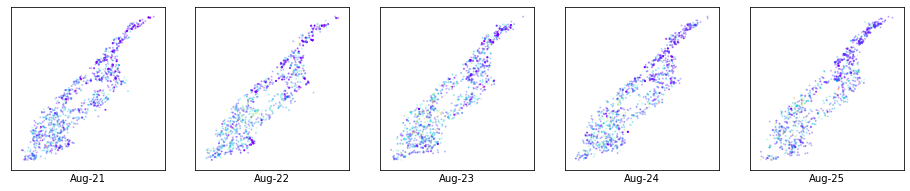

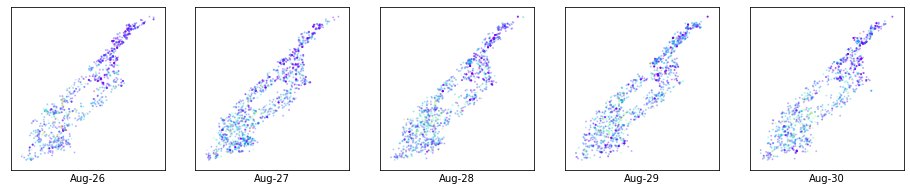

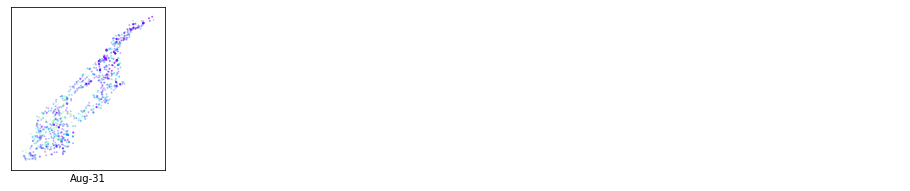

In [19]:
plot_serie(D, 'Date', 'Agency')

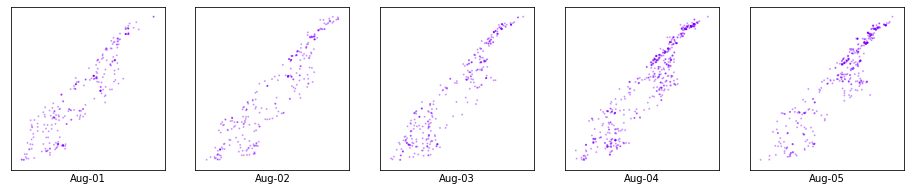

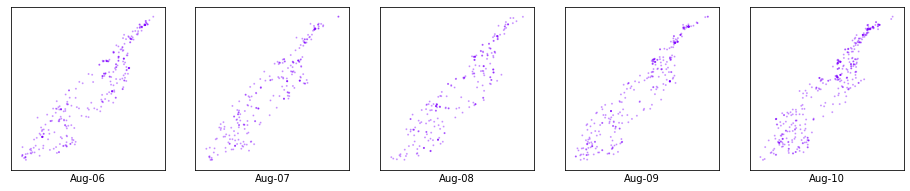

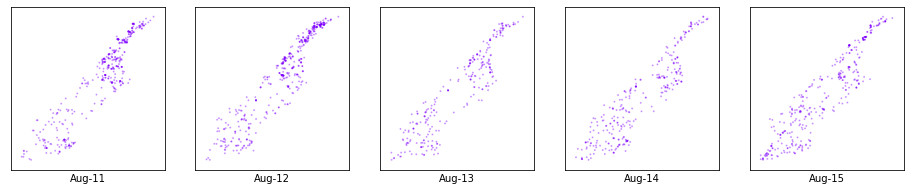

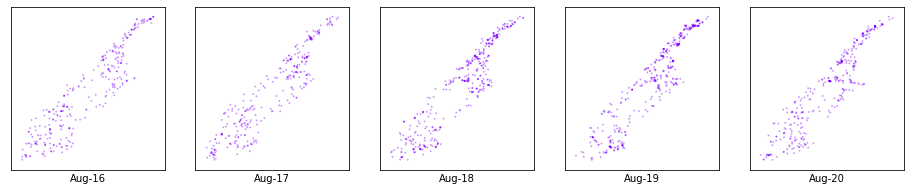

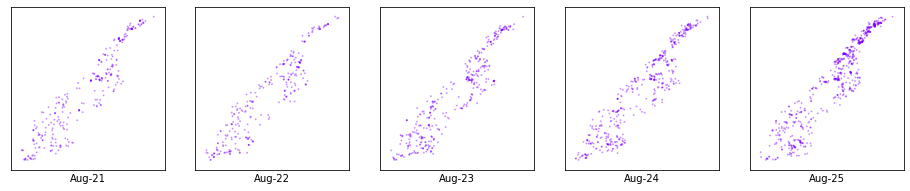

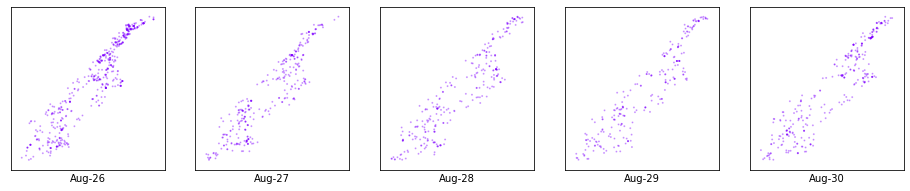

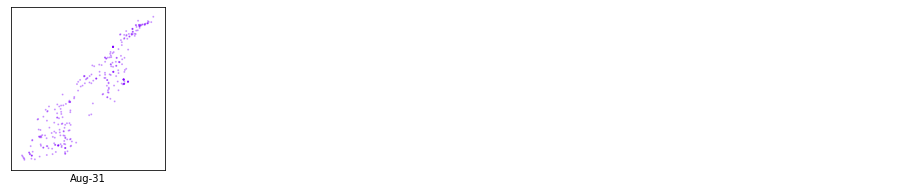

In [20]:
# show NYPD only
plot_serie(D[D['Agency'] == 2], 'Date', 'Agency')

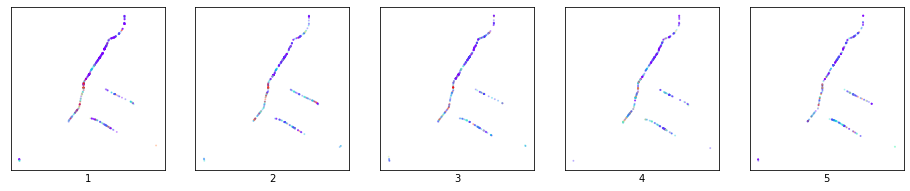

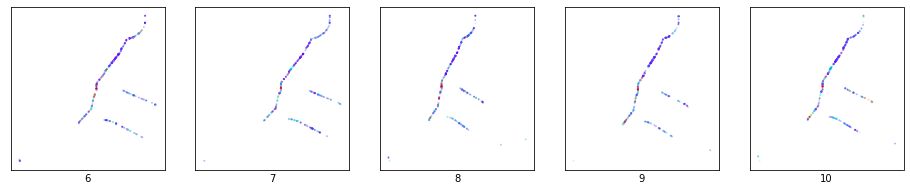

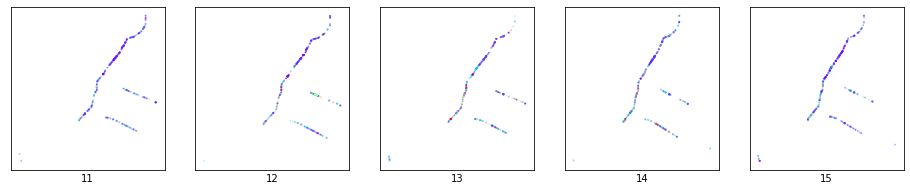

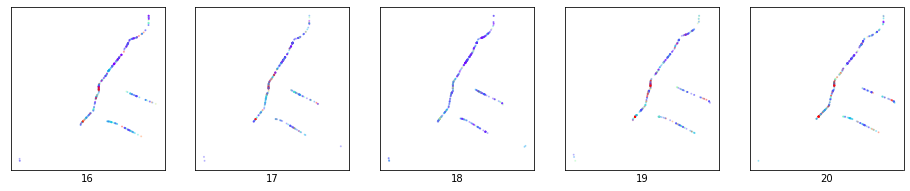

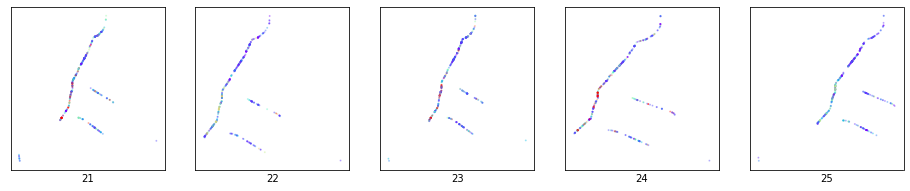

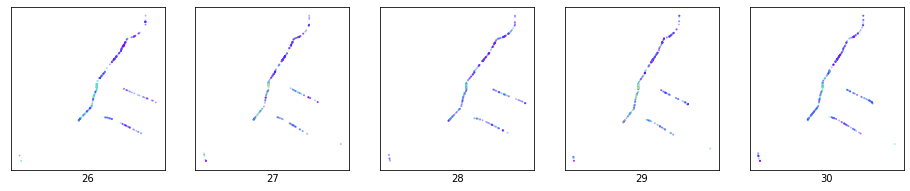

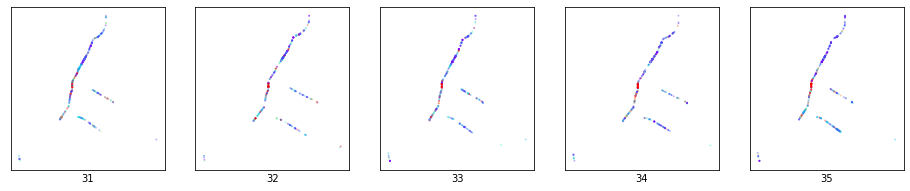

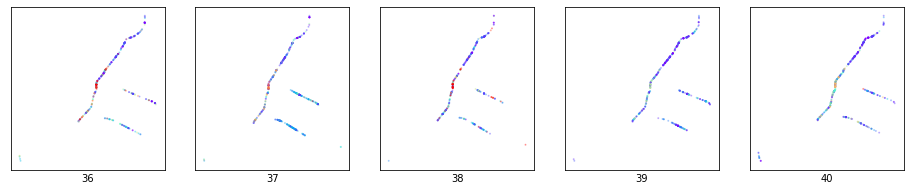

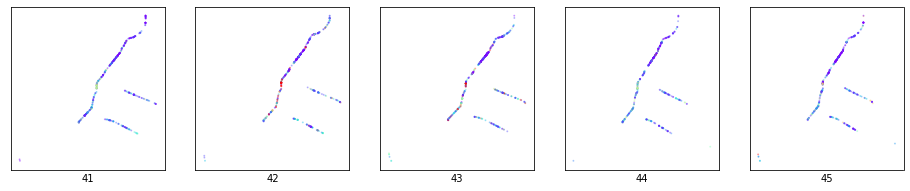

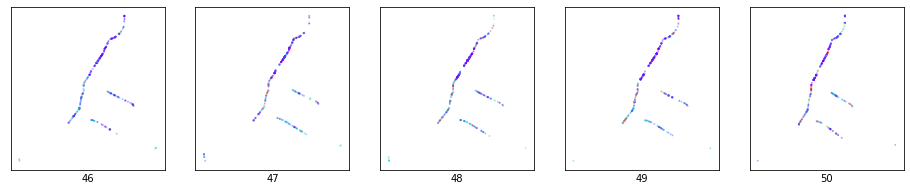

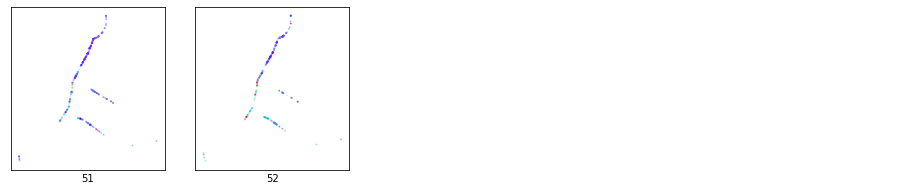

In [21]:
# weekly Broadway
data['Week'] = data['Created Date'].dt.week
cond = (data['Street Name'] == 1)

D = data[cond][['Week','Agency','Latitude','Longitude']].dropna()
plot_serie(D, 'Week', 'Agency')

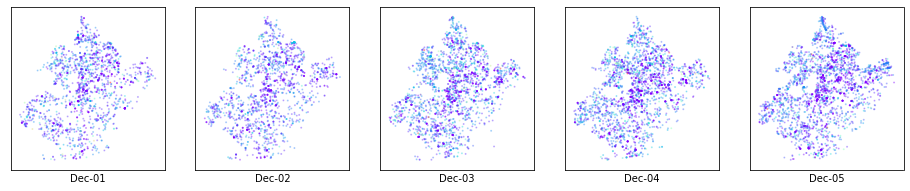

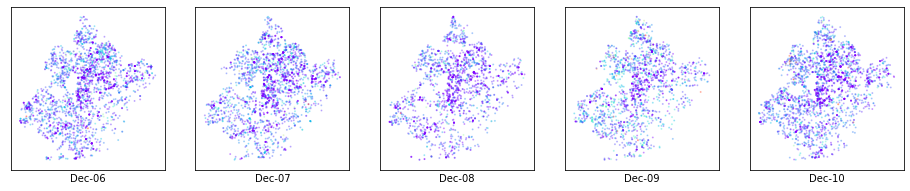

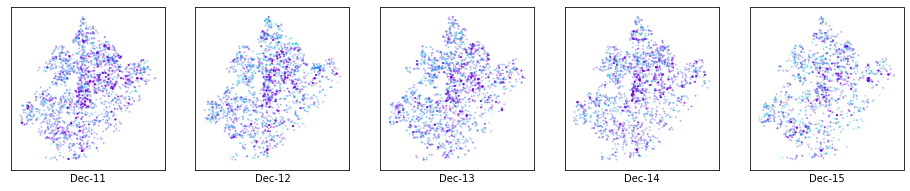

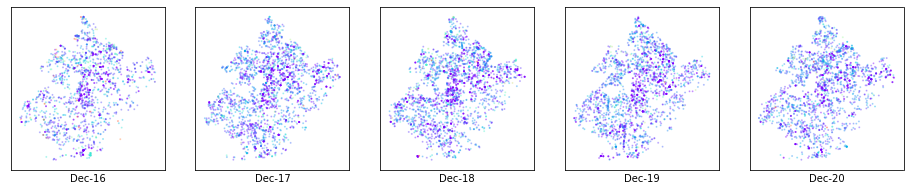

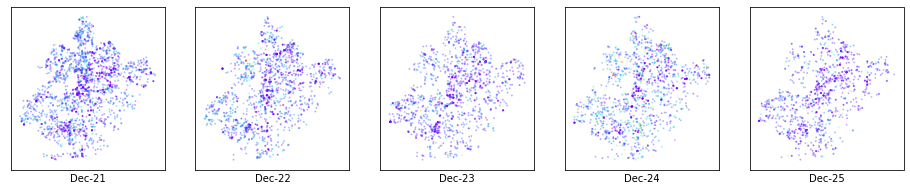

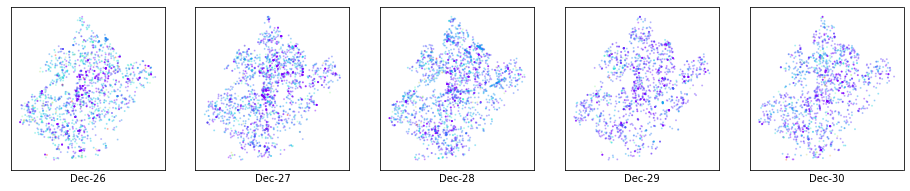

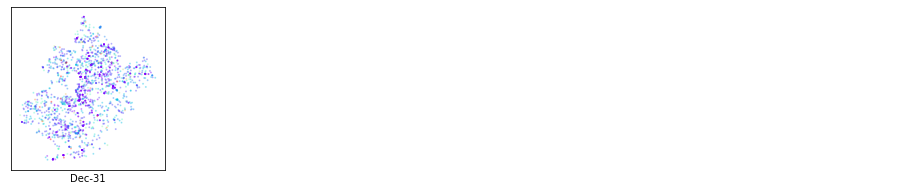

In [22]:
# December NY Borough
cond = (data['Borough'] == 1) & (data['Created Date'].dt.month == 12)

D = data[cond][['Date','Agency','Latitude','Longitude']].dropna()
plot_serie(D, 'Date', 'Agency')